**1. Introduction**

This notebook aims to visualize and analyze the Performance Ratio (PR) of a solar photovoltaic (PV) system over time. The PR is a crucial metric that indicates the actual energy yield of a PV system relative to its theoretical maximum, after accounting for losses.

**Objective:**

• Load and combine PR and Global Horizontal Irradiance (GHI) data from various CSV files.

• Visualize the daily PR, its 30-day moving average, and a target budget PR.

• Highlight the impact of GHI on daily PR.

• Provide key statistical summaries of PR performance over different durations.

**2. Setup and Data Loading**

First, we'll import the necessary Python libraries and define the functions to load and preprocess our data.

In [79]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Recursively combine CSV files from folder and subfolders for a specific column
def combine_csvs_recursive(folder_path, value_col):
    combined_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                try:
                    df = pd.read_csv(os.path.join(root, file))
                    combined_list.append(df[['Date', value_col]])
                except:
                    pass  # Skip unreadable or malformed files
    combined_df = pd.concat(combined_list, ignore_index=True)
    return combined_df.sort_values('Date').drop_duplicates().reset_index(drop=True)

# Folder paths for GHI and PR data
ghi_folder = r"C:\Users\deepa\OneDrive_1_5-31-2025\data\GHI"
pr_folder = r"C:\Users\deepa\OneDrive_1_5-31-2025\data\PR"

# Combine CSVs in each folder
ghi_df = combine_csvs_recursive(ghi_folder, 'GHI')
pr_df = combine_csvs_recursive(pr_folder, 'PR')

# Save combined CSVs
ghi_df.to_csv(os.path.join(ghi_folder, "combined_GHI.csv"), index=False)
pr_df.to_csv(os.path.join(pr_folder, "combined_PR.csv"), index=False)

# Merge combined data on 'Date' with inner join and remove duplicates
merged_df = pd.merge(ghi_df, pr_df, on='Date', how='inner').drop_duplicates()

# Save merged dataset
merged_df.to_csv(r"C:\Users\deepa\OneDrive_1_5-31-2025\data\merged_GHI_PR.csv", index=False)

print("🔥 Done! Combined and merged CSVs with duplicates removed.")

🔥 Done! Combined and merged CSVs with duplicates removed.


In [80]:
# Load the merged GHI and PR dataset from the specified CSV file
data = pd.read_csv(r"C:\Users\deepa\OneDrive_1_5-31-2025\data\merged_GHI_PR.csv")

In [81]:
# Display the first 5 rows of the merged DataFrame to preview the data
data.head()

,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-02,3.976767,79.314411
2,2019-07-03,2.811867,61.020006
3,2019-07-04,3.658408,83.262576
4,2019-07-05,5.590683,82.124440


In [82]:
# Display a concise summary of the DataFrame, including column names, non-null counts, and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    982 non-null    object 
 1   GHI     982 non-null    float64
 2   PR      982 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.1+ KB


**3. Performance Ratio Visualization**

We define the core plotting function. This function takes the processed data and generates an insightful visualization of the PR, including moving averages, budget targets, and GHI-based coloring.

Successfully loaded 'merged_GHI_PR.csv'


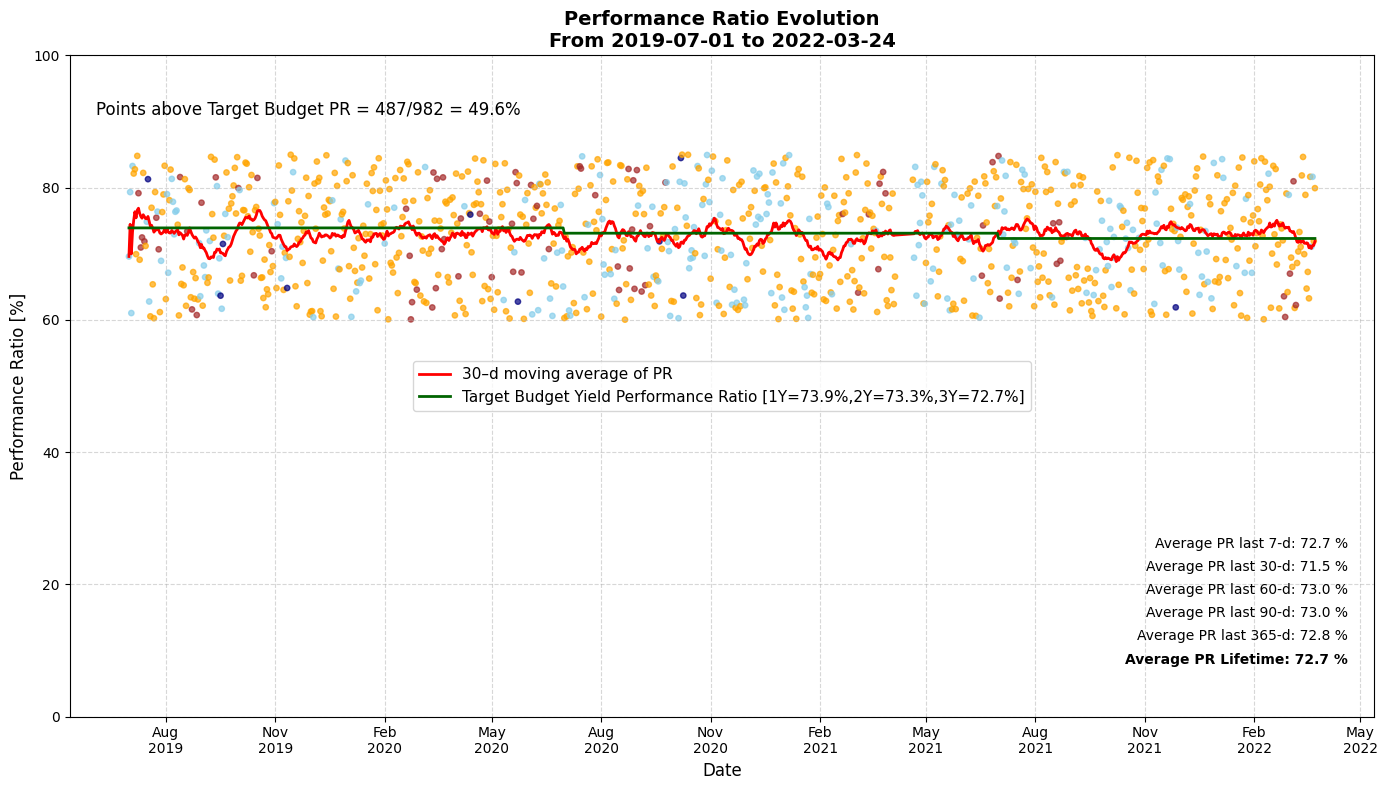

In [85]:
def plot_pr_reference_style(data, start_date=None, end_date=None):
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna(subset=['Date', 'PR', 'GHI'])

    if data.empty:
        print("⚠️ No data available after cleaning or in the selected date range.")
        return

    # Filter data based on start_date and end_date if provided
    if start_date:
        data = data.loc[(data['Date'] >= pd.to_datetime(start_date))]
    if end_date:
        data = data.loc[(data['Date'] <= pd.to_datetime(end_date))]

    if data.empty:
        print("⚠️ No data in the selected date range.")
        return

    data = data.sort_values('Date').reset_index(drop=True)
    data['PR_MA_30'] = data['PR'].rolling(window=30, min_periods=1).mean()

    def budget_pr(date):
        start = pd.Timestamp('2019-07-01')
        years = (date.year - start.year) + (0 if date.month >= 7 else -1)
        return max(70.0, 73.9 - 0.8 * years)

    data['Budget_PR'] = data['Date'].apply(budget_pr)

    def ghi_color(val):
        if pd.isna(val):
            return 'grey'
        if val < 2:
            return 'navy'
        elif val < 4:
            return 'skyblue'
        elif val < 6:
            return 'orange'
        else:
            return 'brown'

    data['Color'] = data['GHI'].apply(ghi_color)

    fig, ax = plt.subplots(figsize=(14, 8))

    start_str = data['Date'].min().strftime('%Y-%m-%d')
    end_str = data['Date'].max().strftime('%Y-%m-%d')
    ax.set_title(f"Performance Ratio Evolution\nFrom {start_str} to {end_str}",
                 fontsize=14, weight='bold')

    ax.scatter(data['Date'], data['PR'], color=data['Color'], s=15, alpha=0.7)

    pr_avg_line, = ax.plot(data['Date'], data['PR_MA_30'], color='red', linewidth=2,
                            label='30–d moving average of PR')
    budget_line, = ax.plot(data['Date'], data['Budget_PR'], color='darkgreen', linewidth=2,
                            label='Target Budget Yield Performance Ratio [1Y=73.9%,2Y=73.3%,3Y=72.7%]')

    above_target = data.loc[(data['PR'] > data['Budget_PR'])]
    if not data.empty:
        pct_above = len(above_target) / len(data) * 100
        ax.text(0.02, 0.91,
                f"Points above Target Budget PR = {len(above_target)}/{len(data)} = {pct_above:.1f}%",
                transform=ax.transAxes, fontsize=12)
    else:
        ax.text(0.02, 0.91,
                "No data points to calculate 'Points above Target Budget PR'",
                transform=ax.transAxes, fontsize=12)

    today = data['Date'].max()
    stat_lines = []
    if pd.isna(today):
        stat_lines.append("No data to calculate statistics.")
    else:
        for d in [7, 30, 60, 90, 365]:
            recent = data.loc[(data['Date'] >= today - pd.Timedelta(days=d))]
            if not recent.empty:
                stat_lines.append(f"Average PR last {d}-d: {recent['PR'].mean():.1f} %")
            else:
                stat_lines.append(f"Average PR last {d}-d: N/A % (No data)")
        if not data.empty:
            stat_lines.append(f"Average PR Lifetime: {data['PR'].mean():.1f} %")
        else:
            stat_lines.append("Average PR Lifetime: N/A % (No data)")

    base_x = 0.98
    base_y = 0.08
    y_increment = 0.035
    num_stats = len(stat_lines)
    for i, line in enumerate(stat_lines):
        current_y = base_y + (num_stats - 1 - i) * y_increment
        ax.text(base_x, current_y, line,
                transform=ax.transAxes, fontsize=10,
                fontweight='bold' if 'Lifetime' in line else 'normal',
                ha='right')

    ghi_legend = [
        plt.Line2D([0], [0], marker='o', color='w', label='< 2', markerfacecolor='navy', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='2 – 4', markerfacecolor='skyblue', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='4 – 6', markerfacecolor='orange', markersize=8),
        plt.Line2D([0], [0], marker='o', color='w', label='> 6', markerfacecolor='brown', markersize=8)
    ]
    ax.legend(handles=ghi_legend, loc='upper center', fontsize=10,
              bbox_to_anchor=(0.5, 1.08), ncol=4, title="Daily Irradiation [kWh/m2]")

    ax.legend(handles=[pr_avg_line, budget_line], loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=11)

    ax.set_ylabel("Performance Ratio [%]", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        data = pd.read_csv(r"C:\Users\deepa\OneDrive_1_5-31-2025\data\merged_GHI_PR.csv")
        print("Successfully loaded 'merged_GHI_PR.csv'")
        # Optionally, you can set the date range to match the image
        plot_pr_reference_style(data, start_date='2019-07-01', end_date='2022-03-24')
    except FileNotFoundError:
        print("Error: 'merged_GHI_PR.csv' not found. Please make sure the file is in the specified path.")
    except Exception as e:
        print(f"An error occurred: {e}")


**4. Data Visualization and Analysis**

Now, we'll use the ***plot_pr_reference_style*** function to visualize our merged PR and GHI data. We'll also calculate and display the statistical summaries of PR for various timeframes.

In [84]:
def pr_stats(data, date_col='Date', pr_col='PR'):
    # Convert Date column to datetime
    data[date_col] = pd.to_datetime(data[date_col])
    
    # Sort data by date (optional but good practice)
    data = data.sort_values(date_col)
    
    # Overall PR stats
    print("Overall PR stats:")
    print(data[pr_col].describe())
    
    latest_date = data[date_col].max()
    
    rolling_days = [7, 30, 60, 90, 365]
    for days in rolling_days:
        window_start = latest_date - pd.Timedelta(days=days)
        subset = data[data[date_col] >= window_start][pr_col]
        
        if subset.empty:
            print(f"No data for last {days} days")
        else:
            mean_val = subset.mean()
            median_val = subset.median()
            print(f"\nLast {days} days PR stats:")
            print(subset.describe())
            print(f"Mean PR last {days} days: {mean_val:.1f}%")
            print(f"Median PR last {days} days: {median_val:.1f}%")
    
    # Lifetime average and median
    lifetime_mean = data[pr_col].mean()
    lifetime_median = data[pr_col].median()
    print(f"\nLifetime Mean PR: {lifetime_mean:.1f}%")
    print(f"Lifetime Median PR: {lifetime_median:.1f}%")


pr_stats(data)

Overall PR stats:
count    982.000000
mean      72.714933
std        7.294222
min       60.023886
25%       66.309422
50%       72.947945
75%       79.111721
max       84.980120
Name: PR, dtype: float64

Last 7 days PR stats:
count     8.000000
mean     72.668682
std       7.537721
min      63.243977
25%      66.612537
50%      71.481751
75%      80.341726
max      81.632738
Name: PR, dtype: float64
Mean PR last 7 days: 72.7%
Median PR last 7 days: 71.5%

Last 30 days PR stats:
count    31.000000
mean     71.529192
std       7.132412
min      60.425349
25%      65.852856
50%      71.026924
75%      78.897798
max      84.632014
Name: PR, dtype: float64
Mean PR last 30 days: 71.5%
Median PR last 30 days: 71.0%

Last 60 days PR stats:
count    61.000000
mean     73.045519
std       7.183406
min      60.084250
25%      67.998135
50%      72.933442
75%      79.102042
max      84.632014
Name: PR, dtype: float64
Mean PR last 60 days: 73.0%
Median PR last 60 days: 72.9%

Last 90 days PR stats:

**5. Conclusion**

This analysis provides a clear overview of the solar PV system's performance ratio. We can observe:

• **Overall Performance:** The system maintains a lifetime average PR of approximately 72.7%, which is a solid indicator of its efficiency.

• **Trends:** The 30-day moving average helps identify short-term performance trends, while the budget PR line serves as a benchmark for expected degradation.

• **GHI Impact:** The GHI-colored scatter points visually demonstrate how PR might vary under different irradiation conditions (e.g., lower GHI days sometimes showing lower PR, or vice versa, depending on system characteristics).

• **Performance vs. Budget:** The percentage of points above the target budget provides a quick metric of system adherence to expected performance.